In [1]:
!pip install pycocoevalcap
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 17.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00


In [2]:
import torch
import gc

gc.collect()                      # gom rác Python
torch.cuda.empty_cache()          # trả lại VRAM chưa dùng cho driver
torch.cuda.ipc_collect()          # dọn shared memory CUDA (nếu có)
!nvidia-smi


Mon Dec 22 09:14:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from torchvision import transforms
from tqdm import tqdm
from datasets import load_dataset
from typing import List
from collections import Counter
import re
import timm
import matplotlib.pyplot as plt
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda


In [4]:
class SimpleTokenizer:
    def __init__(self, vocab: List[str]):
        specials = ["<pad>", "<bos>", "<eos>", "<unk>"]
        vocab = specials + [w for w in vocab if w not in specials]
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.itos = {i: w for w, i in self.stoi.items()}
        self.pad_id = self.stoi["<pad>"]
        self.bos_id = self.stoi["<bos>"]
        self.eos_id = self.stoi["<eos>"]
        self.unk_id = self.stoi["<unk>"]

    def encode(self, text: str) -> List[int]:
        text = text.lower().strip()
        # Tách punctuation
        text = re.sub(r"([.!?,;:])", r" \1 ", text)
        text = re.sub(r"\s+", " ", text).strip()
        tokens = text.split()
        return [self.stoi.get(t, self.unk_id) for t in tokens]

    def decode(self, ids: List[int]) -> str:
        toks = []
        for i in ids:
            if i in (self.pad_id, self.bos_id, self.eos_id):
                continue
            toks.append(self.itos.get(i, "<unk>"))
        return " ".join(toks)


def collect_rsicd_words(hf_train, hf_val, min_freq=3):
    cnt = Counter()
    for split in [hf_train, hf_val]:
        for ex in split:
            cap = ex["captions"]
            if isinstance(cap, list):
                for c in cap:
                    text = c.lower().strip()
                    text = re.sub(r"([.!?,;:])", r" \1 ", text)
                    text = re.sub(r"\s+", " ", text).strip()
                    cnt.update(text.split())
            else:
                text = cap.lower().strip()
                text = re.sub(r"([.!?,;:])", r" \1 ", text)
                text = re.sub(r"\s+", " ", text).strip()
                cnt.update(text.split())
    words = [w for w, freq in cnt.most_common() if freq >= min_freq]
    return words


# Load dataset
print("Loading dataset...")
ds = load_dataset("arampacha/rsicd")
rsicd_words = collect_rsicd_words(ds["train"], ds["valid"], min_freq=3)
print(f"RSICD unique words (freq >=3): {len(rsicd_words)}")

try:
    from wordfreq import top_n_list
    gigaword_top = top_n_list("en", n=5000)
    merged = list(dict.fromkeys(rsicd_words + gigaword_top))
    print(f"After adding wordfreq top-5k: {len(merged)}")
except:
    print("Wordfreq not available, using RSICD only")
    merged = rsicd_words

tokenizer = SimpleTokenizer(merged)
print(f"Final vocab size: {len(tokenizer.stoi)}")

Loading dataset...


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

data/valid-00000-of-00001.parquet:   0%|          | 0.00/51.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8734 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1093 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1094 [00:00<?, ? examples/s]

RSICD unique words (freq >=3): 1569
After adding wordfreq top-5k: 5743
Final vocab size: 5747


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
class RSICDDataset(Dataset):
    def __init__(self, hf_split, tokenizer, transform=None, max_len=30, is_train=True, n_caps=5):
        self.data = hf_split
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len
        self.is_train = is_train
        self.n_caps = n_caps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]

        # Load image
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))
        
        if self.transform is not None:
            image = self.transform(image)

        # Get captions
        caps = ex["captions"]
        if isinstance(caps, str):
            caps = [caps]
        caps = [c.strip() for c in caps if isinstance(c, str) and c.strip()]
        caps = caps[:self.n_caps]
        
        # Pad if needed
        while len(caps) < self.n_caps:
            caps.append(caps[0])

        return image, caps


def collate_fn_train(batch):
    """Training collate: random 1 caption per image"""
    images_list = []
    captions_ids = []
    
    for image, caps in batch:
        # Random pick 1 caption
        cap = random.choice(caps)
        images_list.append(image)
        
        ids = tokenizer.encode(cap)
        ids = [tokenizer.bos_id] + ids + [tokenizer.eos_id]
        ids = ids[:max_len]
        pad_len = max_len - len(ids)
        if pad_len > 0:
            ids = ids + [tokenizer.pad_id] * pad_len
        captions_ids.append(torch.tensor(ids, dtype=torch.long))
    
    images = torch.stack(images_list, dim=0)
    captions_ids = torch.stack(captions_ids, dim=0)
    
    return images, captions_ids, None


def collate_fn_eval(batch):
    """Evaluation collate: keep all 5 captions"""
    images_list = []
    all_caps_batch = []
    
    for image, caps in batch:
        images_list.append(image)
        all_caps_batch.append(caps)
    
    images = torch.stack(images_list, dim=0)
    
    return images, None, all_caps_batch
def collate_fn_scst(batch):
    """
    SCST collate: Trả về images và TẤT CẢ captions (để tính CIDEr reward)
    """
    images_list = []
    all_caps_batch = []
    
    for image, caps in batch:
        images_list.append(image)
        all_caps_batch.append(caps)  # Giữ nguyên 5 captions
    
    images = torch.stack(images_list, dim=0)
    
    return images, None, all_caps_batch

In [6]:
class ViTEncoder(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224.mae",
        output_dim=768,
        dropout_p=0.2,
        n_finetune_blocks=6,
        use_task_cls=True
    ):
        super().__init__()
        vit = timm.create_model(model_name, pretrained=True)
        vit.head = nn.Identity()
        self.vit = vit
        vit_dim = vit.num_features

        # Freeze tất cả, mở n_finetune_blocks cuối
        for p in self.vit.parameters():
            p.requires_grad = False
        
        if n_finetune_blocks > 0:
            for blk in self.vit.blocks[-n_finetune_blocks:]:
                for p in blk.parameters():
                    p.requires_grad = True
        
        for p in self.vit.norm.parameters():
            p.requires_grad = True

        # Task-specific CLS token
        self.use_task_cls = use_task_cls
        if use_task_cls:
            self.task_cls = nn.Parameter(torch.zeros(1, 1, vit_dim))
            nn.init.trunc_normal_(self.task_cls, std=0.02)

        # Improved projection head
        self.proj = nn.Sequential(
            nn.Linear(vit_dim, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout_p),
            nn.Linear(output_dim * 2, output_dim),
            nn.LayerNorm(output_dim),
            nn.Dropout(dropout_p * 0.5)
        )
        
        # Spatial attention for better patch features
        self.spatial_attn = nn.MultiheadAttention(
            output_dim, num_heads=8, dropout=dropout_p, batch_first=True
        )

    def forward(self, x):
        B = x.size(0)
        
        # ViT features
        feats = self.vit.forward_features(x)
        
        if self.use_task_cls:
            cls_token = self.task_cls.expand(B, -1, -1)
            patch_tokens = feats[:, 1:, :]
            feats = torch.cat([cls_token, patch_tokens], dim=1)
        
        # Project
        feats = self.proj(feats)
        
        global_feats = feats[:, 0]
        spatial_feats = feats[:, 1:]
        
        # Self-attention on spatial features
        spatial_feats, _ = self.spatial_attn(spatial_feats, spatial_feats, spatial_feats)
        
        return spatial_feats, global_feats


# ============================================================================
# DECODER - Improved Transformer with better architecture
# ============================================================================
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=768,
        nhead=12,
        num_layers=6,
        dim_feedforward=3072,
        dropout=0.2,
        pad_idx=0,
        max_len=128
    ):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.max_len = max_len

        # Embeddings
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embed = nn.Embedding(max_len, d_model)
        
        # Input dropout
        self.input_dropout = nn.Dropout(dropout)

        # Decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation="gelu"
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output layers
        self.out_norm = nn.LayerNorm(d_model)
        self.out_dropout = nn.Dropout(dropout * 0.5)
        
        # Two-layer output head
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5),
            nn.Linear(d_model, vocab_size)
        )

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.normal_(self.embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_embed.weight, mean=0.0, std=0.02)

    def _build_causal_mask(self, T, device):
        mask = torch.full((T, T), float("-inf"), device=device)
        mask = torch.triu(mask, diagonal=1)
        return mask

    def forward(self, spatial_feats, global_feats, caption_ids, enc_padding_mask=None):
        B, T = caption_ids.size()
        device = caption_ids.device

        # Embeddings with scaling
        tok_emb = self.embed(caption_ids) * (self.d_model ** 0.5)
        pos = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        pos_emb = self.pos_embed(pos)
        tgt = tok_emb + pos_emb
        tgt = self.input_dropout(tgt)

        # Memory
        memory = torch.cat([global_feats.unsqueeze(1), spatial_feats], dim=1)

        # Masks
        tgt_mask = self._build_causal_mask(T, device)
        tgt_key_padding_mask = caption_ids.eq(self.pad_idx)

        # Decode
        out = self.decoder(
            tgt,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=enc_padding_mask
        )
        
        out = self.out_norm(out)
        out = self.out_dropout(out)
        logits = self.fc(out)
        
        return logits

In [7]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, caption_ids):
        spatial_feats, global_feats = self.encoder(images)
        logits = self.decoder(spatial_feats, global_feats, caption_ids[:, :-1])
        return logits

    def sample_caption_transformer(self, images, tokenizer, max_len=30, sample=True, temperature=1.0):
        """Fixed sampling with proper log probs"""
        device = images.device
        spatial_feats, global_feats = self.encoder(images)
        
        B = images.size(0)
        bos_id = tokenizer.bos_id
        eos_id = tokenizer.eos_id
        
        seqs = torch.full((B, 1), bos_id, dtype=torch.long, device=device)
        log_probs = []
        
        for t in range(1, max_len):
            logits = self.decoder(spatial_feats, global_feats, seqs)
            step_logits = logits[:, -1, :] / temperature
            step_log_probs = F.log_softmax(step_logits, dim=-1)
            
            if sample:
                probs = step_log_probs.exp()
                next_tokens = torch.multinomial(probs, num_samples=1)
            else:
                next_tokens = step_log_probs.argmax(dim=-1, keepdim=True)
            
            seqs = torch.cat([seqs, next_tokens], dim=1)
            log_probs.append(step_log_probs.gather(1, next_tokens).squeeze(1))
            
            # Early stopping if all beams generated EOS
            if (next_tokens == eos_id).all():
                break
        
        log_probs = torch.stack(log_probs, dim=1) if log_probs else torch.zeros(B, 0, device=device)
        return seqs, log_probs

    def generate_caption_beam(
        self,
        image,
        tokenizer,
        max_len=30,
        beam_size=5,
        alpha=0.7,
        block_ngram=3,
        device="cuda"
    ):
        """Fixed beam search with proper finished handling"""
        self.eval()
        
        if image.dim() == 3:
            image = image.unsqueeze(0)
        image = image.to(device)
        
        spatial_feats, global_feats = self.encoder(image)
        
        bos_id = tokenizer.bos_id
        eos_id = tokenizer.eos_id
        pad_id = tokenizer.pad_id
        vocab_size = self.decoder.vocab_size
        
        # Initialize
        seqs = torch.full((beam_size, 1), bos_id, dtype=torch.long, device=device)
        log_probs = torch.zeros(beam_size, device=device)
        finished = torch.zeros(beam_size, dtype=torch.bool, device=device)
        
        spatial_feats = spatial_feats.expand(beam_size, -1, -1)
        global_feats = global_feats.expand(beam_size, -1)
        
        for t in range(1, max_len + 1):
            if finished.all():
                break
            
            with torch.no_grad():
                logits = self.decoder(spatial_feats, global_feats, seqs)
                step_logits = logits[:, -1, :]
                step_log_probs = F.log_softmax(step_logits, dim=-1)
            
            # Block pad token
            step_log_probs[:, pad_id] = -1e9
            
            # FIXED: Proper handling of finished beams
            total_log_probs = log_probs.unsqueeze(1) + step_log_probs
            
            if finished.any():
                # Finished beams can only generate PAD with same score
                total_log_probs[finished, :] = -1e9
                total_log_probs[finished, pad_id] = log_probs[finished]
            
            # N-gram blocking
            if block_ngram > 0 and seqs.size(1) >= block_ngram:
                for b in range(beam_size):
                    if finished[b]:
                        continue
                    seq_b = seqs[b].tolist()
                    # Block all ngrams that appeared before
                    for i in range(len(seq_b) - block_ngram + 1):
                        ngram = tuple(seq_b[i:i+block_ngram])
                        # Find tokens that would complete this ngram
                        if len(seq_b) >= block_ngram - 1:
                            prefix = tuple(seq_b[-(block_ngram-1):])
                            for tok in range(vocab_size):
                                if prefix + (tok,) == ngram:
                                    total_log_probs[b, tok] -= 5.0
            
            # Select top-k
            flat_log_probs = total_log_probs.view(-1)
            topk_log_probs, topk_indices = flat_log_probs.topk(beam_size, dim=-1)
            
            beam_indices = topk_indices // vocab_size
            token_indices = topk_indices % vocab_size
            
            # Update sequences
            seqs = torch.cat([seqs[beam_indices], token_indices.unsqueeze(1)], dim=1)
            log_probs = topk_log_probs
            finished = finished[beam_indices] | (token_indices == eos_id)
        
        # Length penalty
        lengths = (seqs != pad_id).sum(dim=1).float()
        lengths = torch.clamp(lengths - 1, min=1.0)
        lp = ((5.0 + lengths) / 6.0) ** alpha
        scores = log_probs / lp
        
        # Return best
        best_idx = scores.argmax().item()
        best_seq = seqs[best_idx].tolist()
        best_seq = [tok for tok in best_seq if tok not in (bos_id, eos_id, pad_id)]
        
        return best_seq

In [8]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, vocab_size, padding_idx, smoothing=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            # FIXED: vocab_size - 1 (chỉ trừ padding)
            true_dist.fill_(self.smoothing / (self.vocab_size - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = (target == self.padding_idx)
            true_dist[mask] = 0
        
        loss = -(true_dist * pred).sum(dim=-1)
        loss = loss.masked_fill(mask, 0).sum() / (mask == 0).sum()
        return loss


In [9]:
def train_one_epoch_xe(model, loader, optimizer, criterion, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    
    for images, caption_ids, _ in tqdm(loader, desc="Train (XE)", leave=False):
        images = images.to(device)
        caption_ids = caption_ids.to(device)
        
        logits = model(images, caption_ids)
        target = caption_ids[:, 1:]
        
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            target.reshape(-1)
        )
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def compute_cider_score(refs, hyps, return_per_sample=False):
    cider_scorer = Cider()
    score, scores = cider_scorer.compute_score(refs, hyps)
    return scores if return_per_sample else score


def train_one_epoch_scst_gpu_optimized(
    model, loader, tokenizer, optimizer, device, 
    grad_clip=1.0, accumulation_steps=4
):
    model.train()
    total_loss, total_reward, num_batches = 0.0, 0.0, 0
    optimizer.zero_grad()
    
    pbar = tqdm(loader, desc="Train (SCST)", leave=False)
    for batch_idx, (images, _, all_caps_batch) in enumerate(pbar):
        if all_caps_batch is None:
            continue
        
        images = images.to(device, non_blocking=True)
        B = images.size(0)
        max_len = 20
        
        with torch.cuda.amp.autocast(enabled=False):  # Tắt AMP cho sampling
            # Sample
            sampled_seqs, sampled_log_probs = model.sample_caption_transformer(
                images, tokenizer, max_len=max_len, sample=True, temperature=0.7
            )
            
            # Baseline - không cần gradient
            with torch.no_grad():
                baseline_seqs, _ = model.sample_caption_transformer(
                    images, tokenizer, max_len=max_len, sample=False
                )

        sampled_cpu = sampled_seqs.cpu()
        baseline_cpu = baseline_seqs.cpu()
        
        refs_batch = {}
        sampled_batch = {}
        baseline_batch = {}
        valid_mask = torch.zeros(B, dtype=torch.bool, device=device)
        
        for i in range(B):
            sampled_text = tokenizer.decode(sampled_cpu[i].tolist()).strip()
            baseline_text = tokenizer.decode(baseline_cpu[i].tolist()).strip()
            
            if sampled_text and baseline_text:
                refs_batch[i] = all_caps_batch[i]
                sampled_batch[i] = [sampled_text]
                baseline_batch[i] = [baseline_text]
                valid_mask[i] = True
        
        del sampled_cpu, baseline_cpu  # Free CPU tensors
        
        num_valid = valid_mask.sum().item()
        if num_valid == 0:
            del sampled_seqs, baseline_seqs, sampled_log_probs, valid_mask
            continue
   
        sampled_scores = compute_cider_score(refs_batch, sampled_batch, return_per_sample=True)
        baseline_scores = compute_cider_score(refs_batch, baseline_batch, return_per_sample=True)
        
        # Move rewards to GPU một lần duy nhất
        rewards = torch.zeros(B, device=device, dtype=torch.float32)
        valid_indices = torch.where(valid_mask)[0]
        rewards[valid_mask] = torch.tensor(
            [s - b for s, b in zip(sampled_scores, baseline_scores)],
            device=device, dtype=torch.float32
        )

        # Mask: only valid samples contribute to loss
        seq_mask = (sampled_seqs[:, 1:] != tokenizer.pad_id).float()
        seq_mask = seq_mask * valid_mask.unsqueeze(1).float()
        
        # Loss computation với valid samples only
        weighted_log_probs = sampled_log_probs * seq_mask * rewards.unsqueeze(1)
        loss = -weighted_log_probs.sum() / seq_mask.sum().clamp(min=1.0)
        loss = loss / accumulation_steps
        
        loss.backward()
        
        # Explicitly delete large tensors
        del sampled_seqs, baseline_seqs, sampled_log_probs
        del seq_mask, valid_mask, rewards, weighted_log_probs
        
        # Gradient accumulation
        if (batch_idx + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            # Clear cache less frequently (every accumulation step instead of every batch)
            if (batch_idx + 1) % (accumulation_steps * 4) == 0:
                torch.cuda.empty_cache()
        
        # Metrics tracking
        total_loss += loss.item() * accumulation_steps
        if num_valid > 0:
            avg_sampled = sum(sampled_scores) / len(sampled_scores)
            avg_baseline = sum(baseline_scores) / len(baseline_scores)
            total_reward += (avg_sampled - avg_baseline)
        num_batches += 1
        
        # Update progress
        if batch_idx % 10 == 0:  # Update less frequently
            pbar.set_postfix({
                'loss': f'{loss.item()*accumulation_steps:.3f}',
                'vram': f'{torch.cuda.memory_allocated()/1e9:.1f}GB'
            })
    
    # Final gradient step
    if num_batches % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        optimizer.zero_grad()
    
    # Final cleanup
    torch.cuda.empty_cache()
    
    avg_loss = total_loss / max(num_batches, 1)
    avg_reward = total_reward / max(num_batches, 1)
    return avg_loss, avg_reward


def evaluate(model, loader, tokenizer, criterion, device, max_samples=None):
    """Evaluation with CIDEr"""
    model.eval()
    total_loss = 0.0
    refs, hyps = {}, {}
    idx = 0
    
    with torch.no_grad():
        for images, _, all_caps_batch in tqdm(loader, desc="Eval", leave=False):
            if all_caps_batch is None:
                continue
                
            images = images.to(device)
            B = images.size(0)
            
            for i in range(B):
                if max_samples and idx >= max_samples:
                    break
                
                img = images[i].unsqueeze(0)
                
                token_ids = model.generate_caption_beam(
                    img,
                    tokenizer,
                    max_len=30,
                    beam_size=5,
                    device=device
                )
                
                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1
            
            if max_samples and idx >= max_samples:
                break
    
    # Compute metrics
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)
    
    return bleu_scores[3], cider_score


def test_evaluation(model, loader, tokenizer, device):
    model.eval()
    refs, hyps = {}, {}
    idx = 0
    
    print("Generating captions for test set...")
    with torch.no_grad():
        for images, _, all_caps_batch in tqdm(loader, desc="Test"):
            if all_caps_batch is None:
                continue
                
            images = images.to(device)
            B = images.size(0)
            
            for i in range(B):
                img = images[i].unsqueeze(0)
                
                token_ids = model.generate_caption_beam(
                    img,
                    tokenizer,
                    max_len=30,
                    beam_size=5,
                    device=device
                )
                
                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1
    
    print("\nComputing metrics...")
    results = {'num_samples': idx}
    
    print("  - Computing BLEU...")
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    results['BLEU_1'] = bleu_scores[0]
    results['BLEU_2'] = bleu_scores[1]
    results['BLEU_3'] = bleu_scores[2]
    results['BLEU_4'] = bleu_scores[3]
    
    print("  - Computing METEOR...")
    meteor_scorer = Meteor()
    results['METEOR'], _ = meteor_scorer.compute_score(refs, hyps)
    
    print("  - Computing ROUGE-L...")
    rouge_scorer = Rouge()
    results['ROUGE_L'], _ = rouge_scorer.compute_score(refs, hyps)
    
    print("  - Computing CIDEr...")
    cider_scorer = Cider()
    results['CIDEr'], _ = cider_scorer.compute_score(refs, hyps)
    
    return results, refs, hyps

In [10]:
# Hyperparameters
batch_size = 64  # Tăng vì đã bỏ multi-caption expansion
max_len = 30
n_caps = 5
feat_dim = 768  # Tăng từ 512

# Create datasets
print("\nCreating datasets...")
train_data = RSICDDataset(ds["train"], tokenizer, transform=train_transform,
                          max_len=max_len, is_train=True, n_caps=n_caps)
val_data = RSICDDataset(ds["valid"], tokenizer, transform=val_transform,
                        max_len=max_len, is_train=False, n_caps=n_caps)
test_data = RSICDDataset(ds["test"], tokenizer, transform=val_transform,
                        max_len=max_len, is_train=False, n_caps=n_caps)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, collate_fn=collate_fn_eval)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True, collate_fn=collate_fn_eval)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,
                         num_workers=4, pin_memory=True, collate_fn=collate_fn_eval)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Build model
print("\nBuilding model...")
vocab_size = len(tokenizer.stoi)
pad_idx = tokenizer.pad_id

encoder = ViTEncoder(
    model_name="vit_base_patch16_224.mae",
    output_dim=feat_dim,
    dropout_p=0.2,
    n_finetune_blocks=6,
    use_task_cls=True
)

decoder = TransformerDecoder(
    vocab_size=vocab_size,
    d_model=feat_dim,
    nhead=12,
    num_layers=6,
    dim_feedforward=3072,
    dropout=0.2,
    pad_idx=pad_idx,
    max_len=64
)

model = ImageCaptioningModel(encoder, decoder).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Loss and optimizer
criterion = LabelSmoothingLoss(vocab_size, pad_idx, smoothing=0.1)

optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 1e-5, 'weight_decay': 1e-4},
    {'params': decoder.parameters(), 'lr': 5e-4, 'weight_decay': 1e-3}
])



Creating datasets...
Train: 8734, Val: 1094, Test: 1093

Building model...


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Model parameters: 113,444,723


In [11]:
# print("\n" + "="*70)
# print("PHASE 1: Cross-Entropy Training")
# print("="*70)

# num_epochs_xe = 40
# patience = 10
# best_cider = 0.0
# save_path_xe = "captioner_rsicd_xe_v2.pt"
# epochs_no_improve = 0

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=num_epochs_xe, eta_min=1e-6
# )

# train_losses = []
# val_bleu4s = []
# val_ciders = []

# for epoch in range(num_epochs_xe):
#     train_loss = train_one_epoch_xe(model, train_loader, optimizer, criterion, device)
#     val_bleu4, val_cider = evaluate(model, val_loader, tokenizer, criterion, device)
    
#     train_losses.append(train_loss)
#     val_bleu4s.append(val_bleu4)
#     val_ciders.append(val_cider)
    
#     print(f"\nEpoch {epoch+1}/{num_epochs_xe}")
#     print(f"  Train Loss: {train_loss:.4f}")
#     print(f"  Val BLEU-4: {val_bleu4*100:.2f}, CIDEr: {val_cider:.4f}")
#     print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
#     scheduler.step()
    
#     # Save best model based on CIDEr (better metric than BLEU-4)
#     if val_cider > best_cider:
#         best_cider = val_cider
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'bleu4': val_bleu4,
#             'cider': val_cider,
#         }, save_path_xe)
#         print(f"  ✓ Saved best XE model (CIDEr: {val_cider:.4f})")
#         epochs_no_improve = 0
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve >= patience:
#             print("  Early stopping triggered")
#             break

# # Plot training curves
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Train Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(val_ciders, label='CIDEr', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('CIDEr')
# plt.title('Validation CIDEr')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.savefig('training_xe_curves.png', dpi=150)
# print("\nSaved training curves to 'training_xe_curves.png'")

In [11]:
import torch
import gc

gc.collect()                      # gom rác Python
torch.cuda.empty_cache()          # trả lại VRAM chưa dùng cho driver
torch.cuda.ipc_collect()          # dọn shared memory CUDA (nếu có)
!nvidia-smi


Mon Dec 22 09:15:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             32W /  250W |     935MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----


PHASE 2: SCST Fine-tuning (MEMORY-EFFICIENT)
Loaded XE model (CIDEr: 1.6766)
SCST batch size: 16
Gradient accumulation: 4x (effective batch = 64)
Current VRAM: 2.16GB


Train (SCST):   0%|          | 0/546 [00:00<?, ?it/s]/tmp/ipykernel_47/4271873817.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Tắt AMP cho sampling
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


{'testlen': 11642, 'reflen': 10999, 'guess': [11642, 10548, 9454, 8360], 'correct': [8760, 5452, 3537, 2238]}
ratio: 1.0584598599871753

Epoch 1/25
  Train Loss: -0.1090, Avg Reward: -0.1632
  Val BLEU-4: 44.43, CIDEr: 1.6051
  VRAM: 9.58GB


{'testlen': 11534, 'reflen': 10958, 'guess': [11534, 10440, 9346, 8252], 'correct': [8828, 5533, 3562, 2275]}
ratio: 1.05256433655767

Epoch 2/25
  Train Loss: -0.1293, Avg Reward: -0.1556
  Val BLEU-4: 45.44, CIDEr: 1.6511
  VRAM: 9.58GB


{'testlen': 12013, 'reflen': 11206, 'guess': [12013, 10919, 9825, 8731], 'correct': [9071, 5696, 3670, 2334]}
ratio: 1.0720149919684925

Epoch 3/25
  Train Loss: -0.0791, Avg Reward: -0.1037
  Val BLEU-4: 44.53, CIDEr: 1.6814
  VRAM: 9.58GB
Saved (CIDEr: 1.6814)


{'testlen': 12108, 'reflen': 11249, 'guess': [12108, 11014, 9920, 8826], 'correct': [9060, 5680, 3630, 2351]}
ratio: 1.0763623433193104

Epoch 4/25
  Train Loss: -0.0394, Avg Reward: -0.0661
  Val BLEU-4: 44.04, CIDEr: 1.6630
  VRAM: 9.58GB


{'testlen': 12620, 'reflen': 11501, 'guess': [12620, 11526, 10432, 9338], 'correct': [9318, 5665, 3583, 2267]}
ratio: 1.0972958873140513

Epoch 5/25
  Train Loss: -0.0305, Avg Reward: -0.0635
  Val BLEU-4: 41.71, CIDEr: 1.6106
  VRAM: 9.58GB


{'testlen': 11900, 'reflen': 11164, 'guess': [11900, 10806, 9712, 8618], 'correct': [9055, 5709, 3729, 2393]}
ratio: 1.065926191329177

Epoch 6/25
  Train Loss: -0.0230, Avg Reward: -0.0523
  Val BLEU-4: 45.50, CIDEr: 1.7203
  VRAM: 9.58GB
Saved (CIDEr: 1.7203)


{'testlen': 12125, 'reflen': 11263, 'guess': [12125, 11031, 9937, 8843], 'correct': [9108, 5682, 3693, 2366]}
ratio: 1.0765337831837807

Epoch 7/25
  Train Loss: -0.0212, Avg Reward: -0.0525
  Val BLEU-4: 44.29, CIDEr: 1.6805
  VRAM: 9.58GB


{'testlen': 11656, 'reflen': 11021, 'guess': [11656, 10562, 9468, 8374], 'correct': [8888, 5562, 3589, 2265]}
ratio: 1.05761727610915

Epoch 8/25
  Train Loss: -0.0174, Avg Reward: -0.0418
  Val BLEU-4: 45.05, CIDEr: 1.6988
  VRAM: 9.58GB


{'testlen': 11844, 'reflen': 11045, 'guess': [11844, 10750, 9656, 8562], 'correct': [8854, 5475, 3435, 2126]}
ratio: 1.0723404255318179

Epoch 9/25
  Train Loss: -0.0125, Avg Reward: -0.0328
  Val BLEU-4: 42.82, CIDEr: 1.5991
  VRAM: 9.58GB


{'testlen': 12427, 'reflen': 11319, 'guess': [12427, 11333, 10239, 9145], 'correct': [9166, 5639, 3596, 2269]}
ratio: 1.0978885060516743

Epoch 10/25
  Train Loss: -0.0140, Avg Reward: -0.0393
  Val BLEU-4: 42.29, CIDEr: 1.6043
  VRAM: 9.58GB


{'testlen': 11896, 'reflen': 11121, 'guess': [11896, 10802, 9708, 8614], 'correct': [8928, 5507, 3464, 2176]}
ratio: 1.069687977699751

Epoch 11/25
  Train Loss: -0.0115, Avg Reward: -0.0304
  Val BLEU-4: 43.09, CIDEr: 1.5930
  VRAM: 9.58GB
 Early stopping

Saved curves to 'training_scst_curves.png'


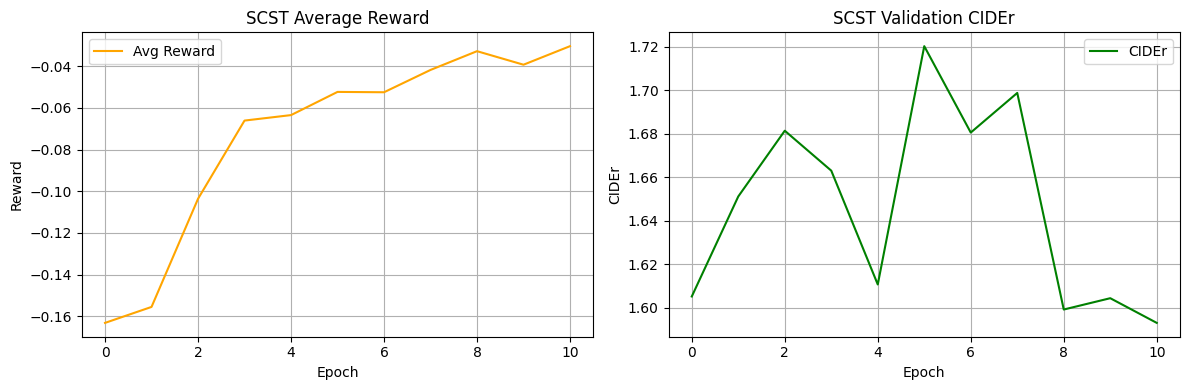

In [13]:
print("\n" + "="*70)
print("PHASE 2: SCST Fine-tuning (MEMORY-EFFICIENT)")
print("="*70)

# Load model
checkpoint = torch.load("/kaggle/input/scst/pytorch/default/1/captioner_rsicd_scst_v2.pt", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded XE model (CIDEr: {checkpoint['cider']:.4f})")

# Clear any cached memory before starting
torch.cuda.empty_cache()

optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 5e-6, 'weight_decay': 1e-4},
    {'params': decoder.parameters(), 'lr': 1e-4, 'weight_decay': 5e-4}
])

# ============================================================================
# CRITICAL: Giảm batch size để tiết kiệm RAM
# ============================================================================
scst_batch_size = 16  # Giảm từ 32 → 16 (hoặc thậm chí 8 nếu vẫn OOM)

scst_train_loader = DataLoader(
    train_data, 
    batch_size=scst_batch_size,
    shuffle=True,
    num_workers=2,  # Giảm workers để tiết kiệm CPU RAM
    pin_memory=False,  # Tắt pin_memory nếu hết RAM
    collate_fn=collate_fn_eval
)

print(f"SCST batch size: {scst_batch_size}")
print(f"Gradient accumulation: 4x (effective batch = {scst_batch_size * 4})")
print(f"Current VRAM: {torch.cuda.memory_allocated()/1e9:.2f}GB")

num_epochs_scst = 25
patience_scst = 5
best_cider_scst = checkpoint['cider']
save_path_scst = "captioner_rsicd_scst_v2.pt"
epochs_no_improve = 0

scst_rewards = []
scst_ciders = []

for epoch in range(num_epochs_scst):
    # Memory-efficient training
    train_loss, avg_reward = train_one_epoch_scst_gpu_optimized(
        model, scst_train_loader, tokenizer, optimizer, device,
        accumulation_steps=4  # Effective batch = 16 * 4 = 64
    )
    
    # Validation với samples giới hạn
    val_bleu4, val_cider = evaluate(
        model, val_loader, tokenizer, criterion, device
    )
    
    scst_rewards.append(avg_reward)
    scst_ciders.append(val_cider)
    
    print(f"\nEpoch {epoch+1}/{num_epochs_scst}")
    print(f"  Train Loss: {train_loss:.4f}, Avg Reward: {avg_reward:.4f}")
    print(f"  Val BLEU-4: {val_bleu4*100:.2f}, CIDEr: {val_cider:.4f}")
    print(f"  VRAM: {torch.cuda.max_memory_allocated()/1e9:.2f}GB")
    
    # Reset memory stats
    torch.cuda.reset_peak_memory_stats()
    
    if val_cider > best_cider_scst:
        best_cider_scst = val_cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bleu4': val_bleu4,
            'cider': val_cider,
        }, save_path_scst)
        print(f"Saved (CIDEr: {val_cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience_scst and epoch >= 10:
            print(" Early stopping")
            break

# Plot curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(scst_rewards, label='Avg Reward', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('SCST Average Reward')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(scst_ciders, label='CIDEr', color='green')
plt.xlabel('Epoch')
plt.ylabel('CIDEr')
plt.title('SCST Validation CIDEr')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_scst_curves.png', dpi=150)
print("\nSaved curves to 'training_scst_curves.png'")

In [13]:
print("\n" + "="*70)
print("PHASE 3: Test Evaluation")
print("="*70)

checkpoint = torch.load(save_path_scst, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

test_results, test_refs, test_hyps = test_evaluation(model, test_loader, tokenizer, device)

print("\n" + "="*70)
print("TEST RESULTS:")
print("="*70)
print(f"Number of test samples: {test_results['num_samples']}\n")
print("Scores:")
print(f"  BLEU-1:  {test_results['BLEU_1']*100:6.2f}")
print(f"  BLEU-2:  {test_results['BLEU_2']*100:6.2f}")
print(f"  BLEU-3:  {test_results['BLEU_3']*100:6.2f}")
print(f"  BLEU-4:  {test_results['BLEU_4']*100:6.2f}")
print(f"  METEOR:  {test_results['METEOR']*100:6.2f}")
print(f"  ROUGE-L: {test_results['ROUGE_L']*100:6.2f}")
print(f"  CIDEr:   {test_results['CIDEr']:6.4f}")

# Save results
output_file = 'test_predictions_v2.json'
predictions = []
for idx in range(min(len(test_refs), 100)):
    predictions.append({
        'image_id': idx,
        'ground_truth': test_refs[idx],
        'prediction': test_hyps[idx][0]
    })

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': {k: float(v) if isinstance(v, (int, float)) else v 
                   for k, v in test_results.items()},
        'predictions': predictions
    }, f, indent=2, ensure_ascii=False)

print(f"\nSaved predictions to '{output_file}'")
print("\n" + "="*70)
print("Training completed!")
print("="*70)


PHASE 3: Test Evaluation
Generating captions for test set...


Test:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Test: 100%|██████████| 18/18 [04:54<00:00, 16.38s/it]



Computing metrics...
  - Computing BLEU...
{'testlen': 12152, 'reflen': 12290, 'guess': [12152, 11059, 9966, 8873], 'correct': [8153, 3765, 1987, 1150]}
ratio: 0.9887713588282352
  - Computing METEOR...
  - Computing ROUGE-L...
  - Computing CIDEr...

TEST RESULTS:
Number of test samples: 1093

Scores:
  BLEU-1:   66.33
  BLEU-2:   47.25
  BLEU-3:   35.31
  BLEU-4:   27.40
  METEOR:   27.23
  ROUGE-L:  51.29
  CIDEr:   0.7192

Saved predictions to 'test_predictions_v2.json'

Training completed!



SAMPLE PREDICTIONS FROM TEST SET:

[Example 1]
Prediction: many buildings and some green trees are located in an industrial area .
Ground Truth: There is a factory with grey roads and roofs.

[Example 2]
Prediction: it is a piece of green mountain .
Ground Truth: several rivers flow through the high mountain.

[Example 3]
Prediction: some buildings and many green trees are located in an average residential area .
Ground Truth: Many grey covered houses are located on both sides of the road.

[Example 4]
Prediction: many buildings and some green trees are close to a viaduct .
Ground Truth: the viaduct is connected to the broad road by a eight shaped ramp .

[Example 5]
Prediction: many storage tanks are close to some green trees .
Ground Truth: Many large storage tanks were built next to the road.

[Example 6]
Prediction: many boats are in a port near many buildings .
Ground Truth: with two bridges crossing the estuary with residential areas along a port and a few sailboats in it.

[Exa

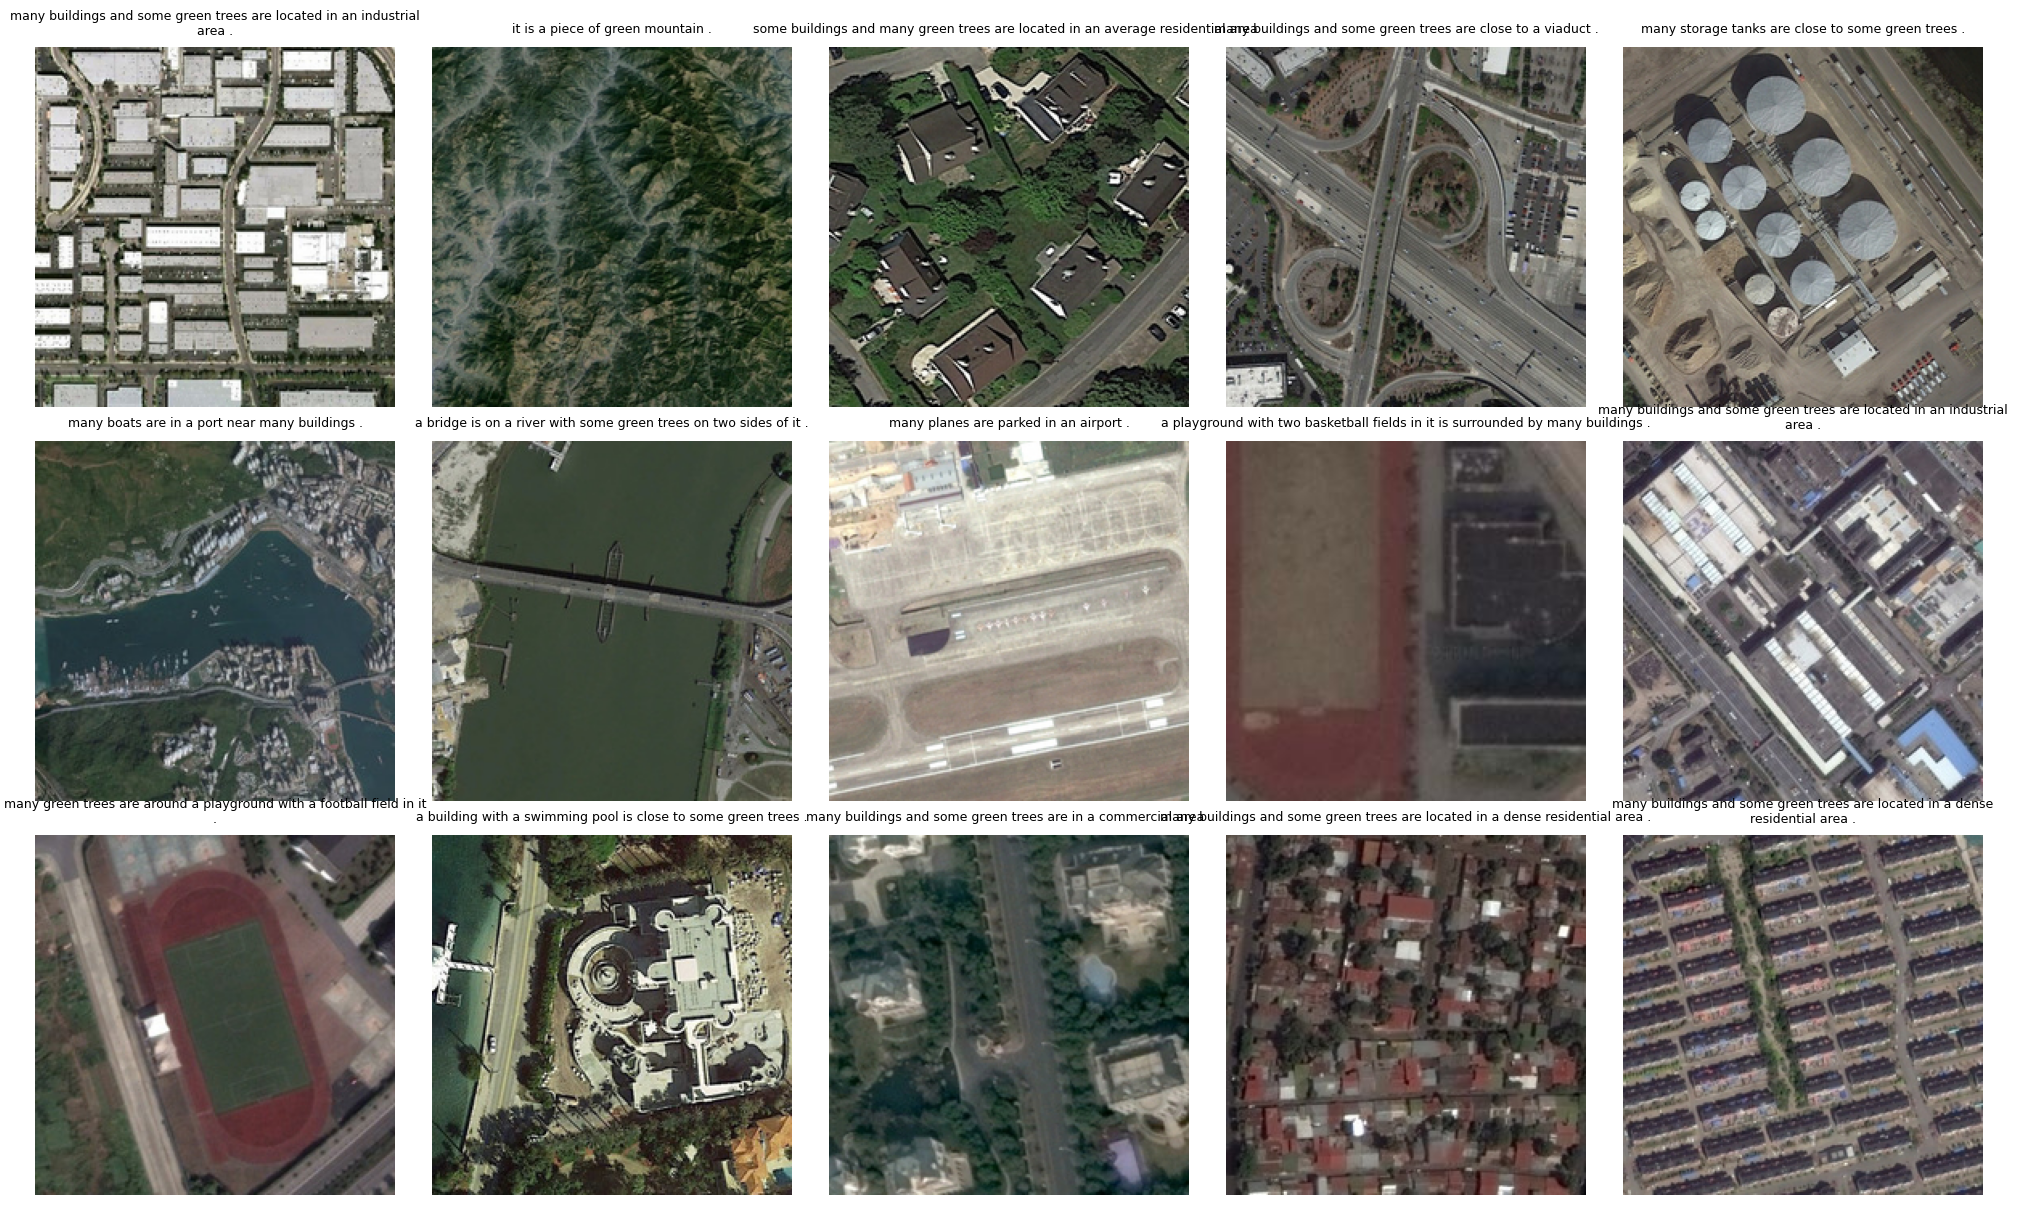


Training completed!


In [14]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS FROM TEST SET:")
print("="*70)

# Visualize random images with predictions
num_examples = 15
indices = random.sample(range(len(test_refs)), min(num_examples, len(test_refs)))

cols = 5
rows = (num_examples + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
axes = axes.flatten()

for ax_idx, img_idx in enumerate(indices):
    ex = test_data.data[img_idx]
    img_path = ex.get("image_path", ex.get("image"))
    
    # Load image
    if isinstance(img_path, str):
        image = Image.open(img_path).convert("RGB")
    else:
        image = ex["image"]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image))
    
    # Display image
    axes[ax_idx].imshow(image)
    axes[ax_idx].axis('off')
    
    # Add prediction as title
    pred = test_hyps[img_idx][0]
    axes[ax_idx].set_title(f"{pred}", fontsize=9, wrap=True, pad=10)
    
    # Print to console
    print(f"\n[Example {ax_idx+1}]")
    print(f"Prediction: {pred}")
    print(f"Ground Truth: {test_refs[img_idx][0]}")

# Hide unused subplots
for ax_idx in range(num_examples, len(axes)):
    axes[ax_idx].axis('off')

plt.tight_layout()
plt.savefig('test_predictions_visual.png', dpi=150, bbox_inches='tight')
print(f"\nSaved visualization to 'test_predictions_visual.png'")
plt.show()

print("\n" + "="*70)
print("Training completed!")
print("="*70)